Name: Sau Chow 100% - Student ID: 000734527
Name: Weifeng Ma 0%

Project Name: Movie Success Prediction Project
Class: CMPE255

This section includes data collection, dadta preprocessing and exploratory data analysis

Load and merge datasets 
tmdb_5000_movies.csv
all_movie.csv merged into
OMdb_mojo_clean.csv - used for exploratory data analysis

In [1]:
!pip install dython
!pip install cpi

import pandas as pd
import numpy as np
import cpi

from sklearn.preprocessing import OneHotEncoder
from functools import partial
from sklearn.feature_selection import SelectKBest, mutual_info_classif
import statsmodels.api as sm
import matplotlib.pyplot as plt
from dython import nominal

import io


from google.colab import files
uploaded = files.upload()

     |████████████████████████████████| 25.5MB 1.5MB/s 


/usr/local/lib/python3.6/dist-packages/cpi/__init__.py:46: StaleDataWarning: CPI data is out of date. To accurately inflate to today's dollars, you must run `cpi.update()`.
  warnings.warn(StaleDataWarning())
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Saving all_movie.csv to all_movie.csv
Saving OMdb_mojo_clean.csv to OMdb_mojo_clean.csv
Saving tmdb_5000_movies.csv to tmdb_5000_movies.csv


In [2]:
OMdb = pd.read_csv('OMdb_mojo_clean.csv', na_values = ['NaN', 'inf'])

In [3]:
tmdb = pd.read_csv('tmdb_5000_movies.csv', na_values = ['NaN', 'inf'])

In [4]:
all_movie = pd.read_csv('all_movie.csv', na_values = ['NaN', 'inf'])

From all_movie.csv, merge Writer1 through Writer4 into OMdb_mojo_clean.csv
for matching movies by “Title” in all_movie.csv

In [5]:
movie_writers = all_movie.loc[:, (all_movie.columns.str.startswith('Write')) | (all_movie.columns == 'Title')]

In [6]:
OMdb = OMdb.merge(movie_writers, how = 'left', left_on = 'Title', right_on = 'Title')

In [7]:
OMdb.shape

(1288, 53)

From tmdb_5000_movies.csv merge “budget” field into OMdb_mojo_clean.csv by
matching movie “title”

In [8]:
tmdb_new = tmdb[['title', 'budget']]

In [9]:
OMdb = OMdb.merge(tmdb_new, how = 'left', left_on = 'Title', right_on = 'title')

In [10]:
OMdb.drop(columns = ['title'], inplace = True)

From Cast1 to Cast 6 all_movie.csv merge into OMdb_mojo_clean.csv by
matching “Title”

In [11]:
movie_casts = all_movie.loc[:, (all_movie.columns.str.startswith('Cast')) | (all_movie.columns == 'Title')]

In [12]:
OMdb = OMdb.merge(movie_casts, how = 'left', left_on = 'Title', right_on = 'Title')

In [13]:
OMdb.shape

(3564, 60)

In [14]:
OMdb = OMdb.drop_duplicates(keep ='first')

In [15]:
OMdb[OMdb['Title'] == 'The Jungle Book']

,Actors,Awards,BoxOffice,Country,DVD,Director,Genre,IMdb_ID,IMdb_score,Language,Metascore,Plot,Production,RT_score,Rated,Released,Runtime,TMdb_id,Title,Type,Website,Year,actor_1,actor_2,awards,bo_year,bo_year_rank,director_1,director_2,domestic-gross,domestic-pct,imdbVotes,itunes_id,logBoxOffice,mojo_title,nominations,num_actor,num_director,num_genre,num_lang,oscar_noms,oscar_wins,overseas-gross,overseas-pct,search_strs,studio,titles,worldwide-gross,years,Writer 1,Writer 2,Writer 3,Writer 4,budget,Cast 1,Cast 2,Cast 3,Cast 4,Cast 5,Cast 6
1,"Neel Sethi, Bill Murray, Ben Kingsley, Idris Elba",Won 1 Oscar. Another 31 wins & 54 nominations.,363995937.0,"UK, USA",30 Aug 2016,Jon Favreau,"Adventure, Drama, Family, Fantasy",tt3040964,74.0,English,77.0,After a threat from the tiger Shere Khan force...,Walt Disney Pictures,95.0,PG,15 Apr 2016,106.0,"[278927, 183407, 534412, 399014]",The Jungle Book,movie,http://movies.disney.com/the-jungle-book-2016,2016,Neel Sethi,Bill Murray,31.0,2016.0,5.0,Jon Favreau,NaN,364000000.0,37.7,231929.0,1098066757,8.561097,The Jungle Book 2016,54.0,4,1,4,1.0,0.0,1.0,602500000.0,62.3,The+Jungle+Book+2016,BV,The Jungle Book (2016),966600000.0,2016,Justin Marks,Writer Not Available,Writer Not Available,Writer Not Available,175000000.0,Neel Sethi,Neel Sethi,Bill Murray,Ben Kingsley,Idris Elba,Lupita Nyong'o
2,"Neel Sethi, Bill Murray, Ben Kingsley, Idris Elba",Won 1 Oscar. Another 31 wins & 54 nominations.,363995937.0,"UK, USA",30 Aug 2016,Jon Favreau,"Adventure, Drama, Family, Fantasy",tt3040964,74.0,English,77.0,After a threat from the tiger Shere Khan force...,Walt Disney Pictures,95.0,PG,15 Apr 2016,106.0,"[278927, 183407, 534412, 399014]",The Jungle Book,movie,http://movies.disney.com/the-jungle-book-2016,2016,Neel Sethi,Bill Murray,31.0,2016.0,5.0,Jon Favreau,NaN,364000000.0,37.7,231929.0,1098066757,8.561097,The Jungle Book 2016,54.0,4,1,4,1.0,0.0,1.0,602500000.0,62.3,The+Jungle+Book+2016,BV,The Jungle Book (2016),966600000.0,2016,Justin Marks,Writer Not Available,Writer Not Available,Writer Not Available,175000000.0,Bruce Reitherman,Louis Prima,Sterling Holloway,J. Pat O'Malley,Darleen Carr,Phil Harris
5,"Neel Sethi, Bill Murray, Ben Kingsley, Idris Elba",Won 1 Oscar. Another 31 wins & 54 nominations.,363995937.0,"UK, USA",30 Aug 2016,Jon Favreau,"Adventure, Drama, Family, Fantasy",tt3040964,74.0,English,77.0,After a threat from the tiger Shere Khan force...,Walt Disney Pictures,95.0,PG,15 Apr 2016,106.0,"[278927, 183407, 534412, 399014]",The Jungle Book,movie,http://movies.disney.com/the-jungle-book-2016,2016,Neel Sethi,Bill Murray,31.0,2016.0,5.0,Jon Favreau,NaN,364000000.0,37.7,231929.0,1098066757,8.561097,The Jungle Book 2016,54.0,4,1,4,1.0,0.0,1.0,602500000.0,62.3,The+Jungle+Book+2016,BV,The Jungle Book (2016),966600000.0,2016,Larry Clemmons,Ken Anderson,Vance Gerry,Ralph Wright,175000000.0,Neel Sethi,Neel Sethi,Bill Murray,Ben Kingsley,Idris Elba,Lupita Nyong'o
6,"Neel Sethi, Bill Murray, Ben Kingsley, Idris Elba",Won 1 Oscar. Another 31 wins & 54 nominations.,363995937.0,"UK, USA",30 Aug 2016,Jon Favreau,"Adventure, Drama, Family, Fantasy",tt3040964,74.0,English,77.0,After a threat from the tiger Shere Khan force...,Walt Disney Pictures,95.0,PG,15 Apr 2016,106.0,"[278927, 183407, 534412, 399014]",The Jungle Book,movie,http://movies.disney.com/the-jungle-book-2016,2016,Neel Sethi,Bill Murray,31.0,2016.0,5.0,Jon Favreau,NaN,364000000.0,37.7,231929.0,1098066757,8.561097,The Jungle Book 2016,54.0,4,1,4,1.0,0.0,1.0,602500000.0,62.3,The+Jungle+Book+2016,BV,The Jungle Book (2016),966600000.0,2016,Larry Clemmons,Ken Anderson,Vance Gerry,Ralph Wright,175000000.0,Bruce Reitherman,Louis Prima,Sterling Holloway,J. Pat O'Malley,Darleen Carr,Phil Harris


In [16]:
def inflate_column(data, column): 
    return data.apply(lambda x:cpi.inflate(x[column], x.Year), axis = 1)

In [17]:
OMdb['real_budget'] = inflate_column(OMdb, 'budget')
OMdb['real_revenue'] = inflate_column(OMdb, 'worldwide-gross')

### Data Preprocessing 

 In OMdb_mojo.clean.csv, clean up the “nan” and “inf” and set them to 0

In [18]:
OMdb._get_numeric_data().isnull().sum().sort_values(ascending = False).head(10)

real_budget        195
budget             195
logBoxOffice       191
BoxOffice          191
overseas-gross      19
bo_year_rank        15
domestic-gross       1
worldwide-gross      0
domestic-pct         0
IMdb_score           0
dtype: int64

In [19]:
OMdb.loc[OMdb['BoxOffice'].isnull(), 'BoxOffice'] = 0

In [20]:
OMdb.loc[OMdb['logBoxOffice'].isnull(), 'logBoxOffice'] = 0

In [21]:
OMdb.loc[OMdb['budget'].isnull(), 'budget'] = 0

In [22]:
OMdb.loc[OMdb['overseas-gross'].isnull(), 'overseas-gross'] = 0

In [23]:
OMdb.loc[OMdb['bo_year_rank'].isnull(), 'bo_year_rank'] = 0

In [24]:
OMdb.loc[OMdb['domestic-gross'].isnull(), 'domestic-gross'] = 0

In [25]:
OMdb._get_numeric_data().isnull().sum().sort_values(ascending = False).head(10)

real_budget     195
real_revenue      0
IMdb_score        0
Metascore         0
RT_score          0
Runtime           0
Year              0
awards            0
bo_year           0
bo_year_rank      0
dtype: int64

In [26]:
OMdb = OMdb.fillna('0')

In [27]:
OMdb.isnull().sum()

Actors          0
Awards          0
BoxOffice       0
Country         0
DVD             0
               ..
Cast 4          0
Cast 5          0
Cast 6          0
real_budget     0
real_revenue    0
Length: 62, dtype: int64

Drop all records in OMdb_mojo_clean.csv that have budget = 0 or empty OR if
revenue = 0 or empty

In [28]:
OMdb = OMdb[(OMdb[['budget', 'worldwide-gross']] != 0).all(axis =1)]

In [29]:
OMdb.shape

(408, 62)

In [30]:
OMdb.to_csv('OMdb_merged.csv', index = False)
from google.colab import files
files.download("OMdb_merged.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Perform hot encoding for all the non-numeric data columns in OMdb_mojo_clean.csv,
need to have the data ready to be fed to sci-kit library calls for logistic regression, KNN, SVM etc.

In [31]:
cat_cols = np.array(pd.DataFrame(OMdb.dtypes[OMdb.dtypes == 'object']).index)

In [32]:
ohe = OneHotEncoder(drop = 'first')

In [33]:
ohe_array = ohe.fit_transform(OMdb[cat_cols]).toarray()

In [34]:
ohe_OMdb = pd.DataFrame(ohe_array, index = OMdb.index, columns = ohe.get_feature_names())

In [35]:
ohe_OMdb.head()

,"x0_Aaron Paul, Dominic Cooper, Imogen Poots, Kid Cudi","x0_Aaron Taylor-Johnson, Chloë Grace Moretz, Morris Chestnut, Claudia Lee","x0_Adam Sandler, Kevin James, Michelle Monaghan, Peter Dinklage","x0_Adewale Akinnuoye-Agbaje, Christopher Eccleston, Grégory Fitoussi, Joseph Gordon-Levitt","x0_Adrien Brody, Topher Grace, Alice Braga, Walton Goggins","x0_Alan Howard, Noel Appleby, Sean Astin, Sala Baker","x0_Alberto Reyes, Julio Oscar Mechoso, Gustavo Sánchez Parra, Adrian Alonso","x0_Alexander Skarsgård, Rory J. Saper, Christian Stevens, Christoph Waltz","x0_Andrew Garfield, Emma Stone, Jamie Foxx, Dane DeHaan","x0_Andrew Garfield, Emma Stone, Rhys Ifans, Denis Leary","x0_Andy Serkis, Jason Clarke, Gary Oldman, Keri Russell","x0_Andy Serkis, Karin Konoval, Terry Notary, Richard Ridings","x0_Angelina Jolie, Elle Fanning, Sharlto Copley, Lesley Manville","x0_Arnold Schwarzenegger, George Clooney, Chris O'Donnell, Uma Thurman","x0_Arnold Schwarzenegger, Jason Clarke, Emilia Clarke, Jai Courtney","x0_Arnold Schwarzenegger, Linda Hamilton, Edward Furlong, Robert Patrick","x0_Ashleigh Anne Aitkenhead, Christopher Bird, Samuel Dent Chapman, Kelly Jackson","x0_Aziz Ansari, Joy Behar, Christopher Campbell, Alain Chabat","x0_Ben Affleck, Henry Cavill, Amy Adams, Jesse Eisenberg","x0_Ben Affleck, Josh Hartnett, Kate Beckinsale, William Lee Scott","x0_Ben Barnes, Georgie Henley, Skandar Keynes, William Moseley","x0_Ben Kingsley, Sacha Baron Cohen, Asa Butterfield, Chloë Grace Moretz","x0_Benicio Del Toro, Dennis Farina, Vinnie Jones, Brad Pitt","x0_Benjamin Walker, Dominic Cooper, Anthony Mackie, Mary Elizabeth Winstead","x0_Bill Nighy, Emily Blunt, Rupert Grint, Rupert Everett","x0_Bill Pullman, Bridget Fonda, Oliver Platt, Brendan Gleeson","x0_Billy Crystal, John Goodman, Steve Buscemi, Helen Mirren","x0_Blake Anderson, Aziz Ansari, Allison Bills, Jim Conroy","x0_Brad Pitt, Angelina Jolie, Vince Vaughn, Adam Brody","x0_Brad Pitt, Catherine Zeta-Jones, George Clooney, Ed Kross","x0_Brad Pitt, Mary-Louise Parker, Brooklynn Proulx, Dustin Bollinger","x0_Brad Pitt, Mireille Enos, Daniella Kertesz, James Badge Dale","x0_Brad Pitt, Mélanie Laurent, Christoph Waltz, Eli Roth","x0_Brad Pitt, Shia LaBeouf, Logan Lerman, Michael Peña","x0_Bradley Cooper, Kyle Gallner, Cole Konis, Ben Reed","x0_Brendan Fraser, Josh Hutcherson, Anita Briem, Seth Meyers","x0_Brenton Thwaites, John Samaha, Courtney Eaton, Nikolaj Coster-Waldau","x0_Bruce Allpress, Sean Astin, John Bach, Sala Baker","x0_Bruce Campbell, Embeth Davidtz, Marcus Gilbert, Ian Abercrombie","x0_Bruce Willis, Bonnie Bedelia, Reginald VelJohnson, Paul Gleason",...,x34_203478061.2244898,x34_204706793.47826087,x34_204830518.74501833,x34_210192717.96941066,x34_212140950.2568262,x34_215582274.8404212,x34_215764736.2089706,x34_217685083.5115298,x34_217993749.45741817,x34_218740036.76054254,x34_222747997.76966748,x34_223266752.31951773,x34_228583338.41476694,x34_230314231.2066625,x34_231435023.04147464,x34_232629565.90788776,x34_233259174.27996823,x34_234092021.4228781,x34_235145539.51758322,x34_240614040.43659678,x34_242530059.19547385,x34_246082541.35561034,x34_249114087.3015873,x34_256231632.65306124,x34_259564567.09856257,x34_261562162.77025253,x34_261569791.6666667,x34_262416571.06496426,x34_265176187.82103273,x34_265862361.037586,x34_266150276.49769583,x34_269477843.5505265,x34_273425045.95067817,x34_274867400.42153704,x34_277399045.38611054,x34_292615026.7785976,x34_296645219.54121435,x34_312457707.5556327,x34_312905919.00311524,x34_363322915.7623636
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

In [36]:
OMdb_drop_col = OMdb.drop(columns = cat_cols)

In [37]:
OMdb_ohed = pd.concat([OMdb_drop_col, ohe_OMdb], axis = 1)

In [38]:
OMdb_ohed.head()

,BoxOffice,IMdb_score,Metascore,RT_score,Runtime,Year,awards,bo_year,bo_year_rank,domestic-gross,domestic-pct,imdbVotes,itunes_id,logBoxOffice,nominations,num_actor,num_director,num_genre,num_lang,oscar_noms,oscar_wins,overseas-gross,overseas-pct,worldwide-gross,years,budget,real_revenue,"x0_Aaron Paul, Dominic Cooper, Imogen Poots, Kid Cudi","x0_Aaron Taylor-Johnson, Chloë Grace Moretz, Morris Chestnut, Claudia Lee","x0_Adam Sandler, Kevin James, Michelle Monaghan, Peter Dinklage","x0_Adewale Akinnuoye-Agbaje, Christopher Eccleston, Grégory Fitoussi, Joseph Gordon-Levitt","x0_Adrien Brody, Topher Grace, Alice Braga, Walton Goggins","x0_Alan Howard, Noel Appleby, Sean Astin, Sala Baker","x0_Alberto Reyes, Julio Oscar Mechoso, Gustavo Sánchez Parra, Adrian Alonso","x0_Alexander Skarsgård, Rory J. Saper, Christian Stevens, Christoph Waltz","x0_Andrew Garfield, Emma Stone, Jamie Foxx, Dane DeHaan","x0_Andrew Garfield, Emma Stone, Rhys Ifans, Denis Leary","x0_Andy Serkis, Jason Clarke, Gary Oldman, Keri Russell","x0_Andy Serkis, Karin Konoval, Terry Notary, Richard Ridings","x0_Angelina Jolie, Elle Fanning, Sharlto Copley, Lesley Manville",...,x34_203478061.2244898,x34_204706793.47826087,x34_204830518.74501833,x34_210192717.96941066,x34_212140950.2568262,x34_215582274.8404212,x34_215764736.2089706,x34_217685083.5115298,x34_217993749.45741817,x34_218740036.76054254,x34_222747997.76966748,x34_223266752.31951773,x34_228583338.41476694,x34_230314231.2066625,x34_231435023.04147464,x34_232629565.90788776,x34_233259174.27996823,x34_234092021.4228781,x34_235145539.51758322,x34_240614040.43659678,x34_242530059.19547385,x34_246082541.35561034,x34_249114087.3015873,x34_256231632.65306124,x34_259564567.09856257,x34_261562162.77025253,x34_261569791.6666667,x34_262416571.06496426,x34_265176187.82103273,x34_265862361.037586,x34_266150276.49769583,x34_269477843.5505265,x34_273425045.95067817,x34_274867400.42153704,x34_277399045.38611054,x34_292615026.7785976,x34_296645219.54121435,x34_312457707.5556327,x34_312905919.00311524,x34_363322915.7623636
1,363995937.0,74.0,77.0000,95.0000,106.0,2016,31.0,2016.0,5.0,364000000.0,37.7,231929.0,1098066757,8.561097,54.0,4,1,4,1.0,0.0,1.0,602500000.0,62.3,966600000.0,2016,175000000.0,1.011304e+09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,363995937.0,74.0,77.0000,95.0000,106.0,2016,31.0,2016.0,5.0,364000000.0,37.7,231929.0,1098066757,8.561097,54.0,4,1,4,1.0,0.0,1.0,602500000.0,62.3,966600000.0,2016,175000000.0,1.011304e+09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,363995937.0,74.0,77.0000,95.0000,106.0,2016,31.0,2016.0,5.0,364000000.0,37.7,231929.0,1098066757,8.561097,54.0,4,1,4,1.0,0.0,1.0,602500000.0,62.3,966600000.0,2016,175000000.0,1.011304e+09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,363995937.0,74.0,77.0000,95.0000,106.0,2016,31.0,2016.0,5.0,364000000.0,37.7,231929.0,1098066757,8.561097,54.0,4,1,4,1.0,0.0,1.0,602500000.0,62.3,966600000.0,2016,175000000.0,1.011304e+09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17,0.0,87.0,101.3592,101.3592,62.0,2010,0.0,2009.0,18.0,137900000.0,42.4,4695.0,616143444,0.000000,0.0,4,1,3,1.0,0.0,0.0,187400000.0,57.6,325300000.0,2010,200000000.0,3.746061e+08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0

In [39]:
OMdb_ohed.to_csv('OMdb_ohed.csv', index = False)

correlation matrix using features which are guessed to have impact on the box office sales: Awards, Director, Genre, IMdb_score, Production, Rated, Writer 4, Writer 3, Runtime, actor_1, actor_2, worldwide-gross, studios, oscar_noms, oscar_wins, writer2, overseas-gross, awards, director_1, director_2, imdb_votes, nomination, writer1, language

In [40]:
corr_df = OMdb[['Awards', 'Runtime','IMdb_score', 'worldwide-gross', 'director_2', 'Production', 'studio',
               'imdbVotes','Rated', 'oscar_noms', 'nominations','Writer 4', 'oscar_wins', 'Writer 1',
               'Writer 3', 'Writer 2', 'Language']]

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4327: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


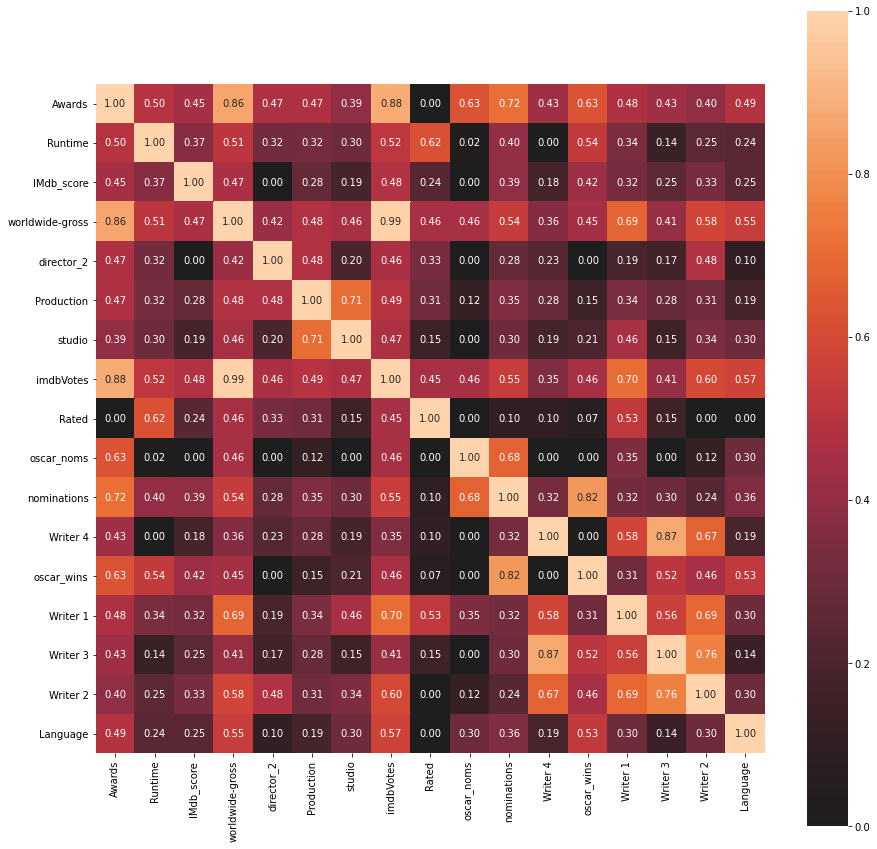

{'ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f3ef1adf9e8>,
 'corr':                    Awards   Runtime  IMdb_score  ...  Writer 3  Writer 2  Language
 Awards           1.000000  0.498322    0.447248  ...  0.432996  0.397614  0.487060
 Runtime          0.498322  1.000000    0.374622  ...  0.136107  0.253086  0.244376
 IMdb_score       0.447248  0.374622    1.000000  ...  0.250538  0.333301  0.246782
 worldwide-gross  0.861721  0.511502    0.467587  ...  0.410146  0.581432  0.550427
 director_2       0.472546  0.318858    0.000000  ...  0.166941  0.482659  0.102017
 Production       0.468967  0.321055    0.278752  ...  0.281491  0.307512  0.186037
 studio           0.392234  0.303633    0.185415  ...  0.151514  0.344771  0.303523
 imdbVotes        0.876652  0.521157    0.478174  ...  0.413639  0.599021  0.574671
 Rated            0.000000  0.623401    0.237136  ...  0.151425  0.000000  0.000000
 oscar_noms       0.628490  0.023250    0.000000  ...  0.000000  0.117667  0.301858
 n

In [41]:
nominal.associations(corr_df, nominal_columns = 'all', figsize=(15, 15), annot =True)

Covariance matrix to determine which features are similar and can be dropped from model input

In [42]:
OMdb.cov()

,BoxOffice,IMdb_score,Metascore,RT_score,Runtime,Year,awards,bo_year,bo_year_rank,domestic-gross,domestic-pct,imdbVotes,itunes_id,logBoxOffice,nominations,num_actor,num_director,num_genre,num_lang,oscar_noms,oscar_wins,overseas-gross,overseas-pct,worldwide-gross,years,budget,real_revenue
BoxOffice,1.465699e+16,2.785724e+08,5.318870e+08,8.449870e+08,8.570473e+08,2.076771e+08,1.004855e+09,2.225949e+08,-1.833287e+09,1.118477e+16,-1.727983e+08,1.688180e+13,4.666333e+13,2.674981e+08,1.898651e+09,8.056479e+05,4.145080e+06,7.131999e+06,5.232280e+06,1.456792e+07,1.124258e+07,1.779285e+16,1.727983e+08,2.897735e+16,2.069310e+08,3.978002e+15,3.093611e+16
IMdb_score,2.785724e+08,8.901110e+01,1.285448e+02,1.997967e+02,8.942127e+01,-1.672337e+01,1.405809e+02,-5.855880e+00,-5.457114e+01,3.831928e+08,-5.846015e+00,1.794625e+06,-6.018291e+08,2.176188e+00,2.250182e+02,-2.529267e-04,3.809076e-01,-2.837597e-01,1.247567e+00,1.713157e+00,5.433276e+00,6.690544e+08,5.846015e+00,1.052265e+09,-1.610601e+01,-1.067577e+07,1.518656e+09
Metascore,5.318870e+08,1.285448e+02,2.794197e+02,3.953371e+02,1.317486e+02,-3.032682e+01,2.674663e+02,-9.548832e+00,-1.014378e+02,7.245057e+08,1.900352e+00,2.383626e+06,-9.814581e+08,3.041169e+00,4.156139e+02,-2.015646e-01,7.634874e-01,2.796795e-01,1.972675e+00,2.584408e+00,1.037505e+01,1.168191e+09,-1.900352e+00,1.892694e+09,-2.914301e+01,1.166205e+07,2.717813e+09
RT_score,8.449870e+08,1.997967e+02,3.953371e+02,6.455101e+02,1.652064e+02,-5.150237e+01,3.336251e+02,-1.191576e+01,-1.201890e+02,1.065602e+09,1.406283e+01,3.564368e+06,-1.505323e+09,8.618769e+00,5.568610e+02,-2.304838e-01,1.164789e+00,-6.701811e-02,2.533842e+00,4.122180e+00,1.285675e+01,1.642225e+09,-1.406283e+01,2.707845e+09,-5.012056e+01,-5.956434e+07,3.938816e+09
Runtime,8.570473e+08,8.942127e+01,1.317486e+02,1.652064e+02,6.916954e+02,-2.759785e+01,3.235966e+02,-1.525701e+01,-2.061659e+02,8.808508e+08,-8.083051e+01,3.829486e+06,-1.199312e+09,1.152124e+01,5.381190e+02,1.244941e-01,-4.832707e-01,-1.733777e+00,2.585327e+00,3.375126e+00,1.983195e+01,2.053579e+09,8.083051e+01,2.934364e+09,-2.713279e+01,5.776831e+08,4.643041e+09
Year,2.076771e+08,-1.672337e+01,-3.032682e+01,-5.150237e+01,-2.759785e+01,6.152247e+01,-1.603353e+01,4.205333e+01,3.914800e+00,1.431889e+07,-4.034432e+01,-2.785982e+05,1.363860e+09,1.279709e+01,1.863304e+01,-3.707183e-02,-4.155225e-01,8.877005e-01,-3.223732e-01,-2.490244e-01,-2.431710e+00,2.069509e+08,4.034432e+01,2.213079e+08,6.056656e+01,1.747774e+08,-4.574719e+08
awards,1.004855e+09,1.405809e+02,2.674663e+02,3.336251e+02,3.235966e+02,-1.603353e+01,9.221810e+02,-9.667582e+00,-2.305966e+02,1.569628e+09,-3.726735e+01,5.908458e+06,-6.078110e+08,3.393095e+00,1.010207e+03,9.972539e-02,1.477092e-01,-1.118659e+00,2.871513e+00,6.028328e-01,3.636291e+01,3.043121e+09,3.726735e+01,4.612800e+09,-1.282946e+01,2.725805e+08,6.435904e+09
bo_year,2.225949e+08,-5.855880e+00,-9.548832e+00,-1.191576e+01,-1.525701e+01,4.205333e+01,-9.667582e+00,5.399940e+01,4.884178e+01,3.026086e+07,-3.825086e+01,-1.710611e+05,1.005934e+09,1.157126e+01,2.503654e+01,-4.072120e-02,4.357566e-02,6.316423e-01,-1.073012e-01,1.671725e-01,-1.979742e+00,2.279313e+08,3.825086e+01,2.582310e+08,4.154871e+01,1.245046e+08,-2.117514e+08
bo_year_rank,-1.833287e+09,-5.457114e+01,-1.014378e+02,-1.201890e+02,-2.061659e+02,3.914800e+00,-2.305966e+02,4.884178e+01,1.245246e+03,-2.612522e+09,1.327019e+02,-3.643413e+06,-7.755714e+08,-6.072429e+00,-3.321092e+02,-9.463615e-01,-7.378595e-01,-6.347738e-01,-3.741346e+00,-2.119598e+00,-1.098920e+01,-4.733622e+09,-1.327019e+02,-7.346101e+09,5.707725e+00,-1.160637e+09,-9.195858e+09
domestic-gross,1.118477e+16,3.831928e+08,7.245057e+08,1.065602e+09,8.808508e+08,1.431889e+07,1.569628e+09,3.026086e+07,-2.612522e+09,1.546362e+16,-1.640279e+08,1.977859e+13,9.727694e+14,8.040850e+07,1.979382e+09,1.074159e+06,4.729172e+06,-7.624752e+06,-3.806384e+05,1.334839e+07,7.951688e+07,2.776572e+16,1.640279e+08,4.322947e+16,1.116479e+07,4.340868e+15,5.406977e+16


### Exploratory Data Analysis
Plot some graphs using OMdb_mojo_clean.csv to explore relationship between certain features and box office sales

Plot revenue by genre. Revenue comes from “worldwide-gross” and “Genre” in OMDb_mojo_clean.csv

In [43]:
OMdb['genre_1'] = [i.split(',')[0] for i in OMdb['Genre'] ]

In [44]:
genre_revenue_df= pd.DataFrame(OMdb.groupby(['genre_1']).sum()['real_revenue'])

In [45]:
genre_revenue_df

,real_revenue
genre_1,
Action,1.280348e+11
Adventure,3.026160e+10
Animation,1.595851e+10
Biography,8.361129e+08
Comedy,1.316947e+09
Crime,4.201440e+09
Drama,1.812665e+10
Romance,1.427791e+08
Short,5.415958e+09


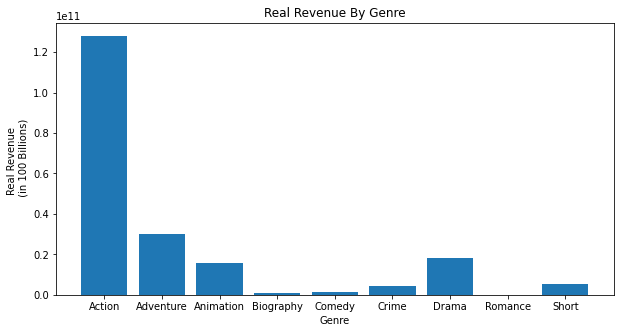

In [46]:
plt.figure(figsize = (10, 5))
plt.bar(genre_revenue_df.index, genre_revenue_df['real_revenue'])
plt.title('Real Revenue By Genre')
plt.xlabel('Genre')
plt.ylabel('Real Revenue \n (in 100 Billions)')
plt.savefig('Real Revenue By Genre.png');

Bin movies by the month that they are released.  Shows which months of the year generate the highest box office sales on average.

In [47]:
month = []
for data in OMdb['Released']:
    if data != '0':
        month.append(pd.to_datetime(data).month)
    else:
        month.append(0)
        
OMdb['month'] = month

In [48]:
OMdb['month'].value_counts()

7     57
12    53
6     50
11    48
5     43
8     40
10    24
1     23
3     18
9     17
4     16
2     15
0      4
Name: month, dtype: int64

In [49]:
month_revenue_df =pd.DataFrame(OMdb.groupby(by = ['month', 'Title']).sum()['real_revenue'])

In [50]:
month_revenue_df.reset_index(inplace = True)

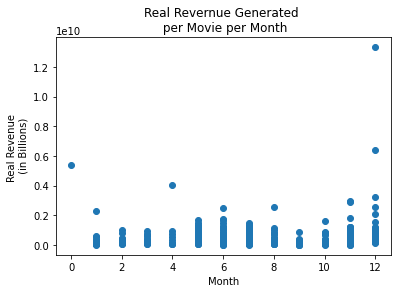

In [51]:
plt.scatter(month_revenue_df['month'], month_revenue_df['real_revenue'])
plt.title('Real Revernue Generated \n per Movie per Month')
plt.xlabel('Month')
plt.ylabel('Real Revenue \n (in Billions)')
plt.savefig('Real Revernue Generated per Movie per Month.png');

Calculate the percentage return on a movie and bin them by director.  Shows which directors have highest return, is there any correlation to box office sales?

In [52]:
OMdb['pct_return'] = OMdb['real_budget']/OMdb['real_revenue']*100

In [53]:
OMdb.columns

Index(['Actors', 'Awards', 'BoxOffice', 'Country', 'DVD', 'Director', 'Genre',
       'IMdb_ID', 'IMdb_score', 'Language', 'Metascore', 'Plot', 'Production',
       'RT_score', 'Rated', 'Released', 'Runtime', 'TMdb_id', 'Title', 'Type',
       'Website', 'Year', 'actor_1', 'actor_2', 'awards', 'bo_year',
       'bo_year_rank', 'director_1', 'director_2', 'domestic-gross',
       'domestic-pct', 'imdbVotes', 'itunes_id', 'logBoxOffice', 'mojo_title',
       'nominations', 'num_actor', 'num_director', 'num_genre', 'num_lang',
       'oscar_noms', 'oscar_wins', 'overseas-gross', 'overseas-pct',
       'search_strs', 'studio', 'titles', 'worldwide-gross', 'years',
       'Writer 1', 'Writer 2', 'Writer 3', 'Writer 4', 'budget', 'Cast 1',
       'Cast 2', 'Cast 3', 'Cast 4', 'Cast 5', 'Cast 6', 'real_budget',
       'real_revenue', 'genre_1', 'month', 'pct_return'],
      dtype='object')

In [54]:
OMdb['pct_return'] = OMdb['pct_return'].astype(float)

In [55]:
OMdb['pct_return'].dtype

dtype('float64')

In [56]:
revenue_director_df = pd.DataFrame(OMdb.groupby(by=['Director']).mean()['pct_return']).sort_values(by = 'pct_return', ascending = False)

In [57]:
revenue_director_df = revenue_director_df.sort_values(by = 'pct_return')

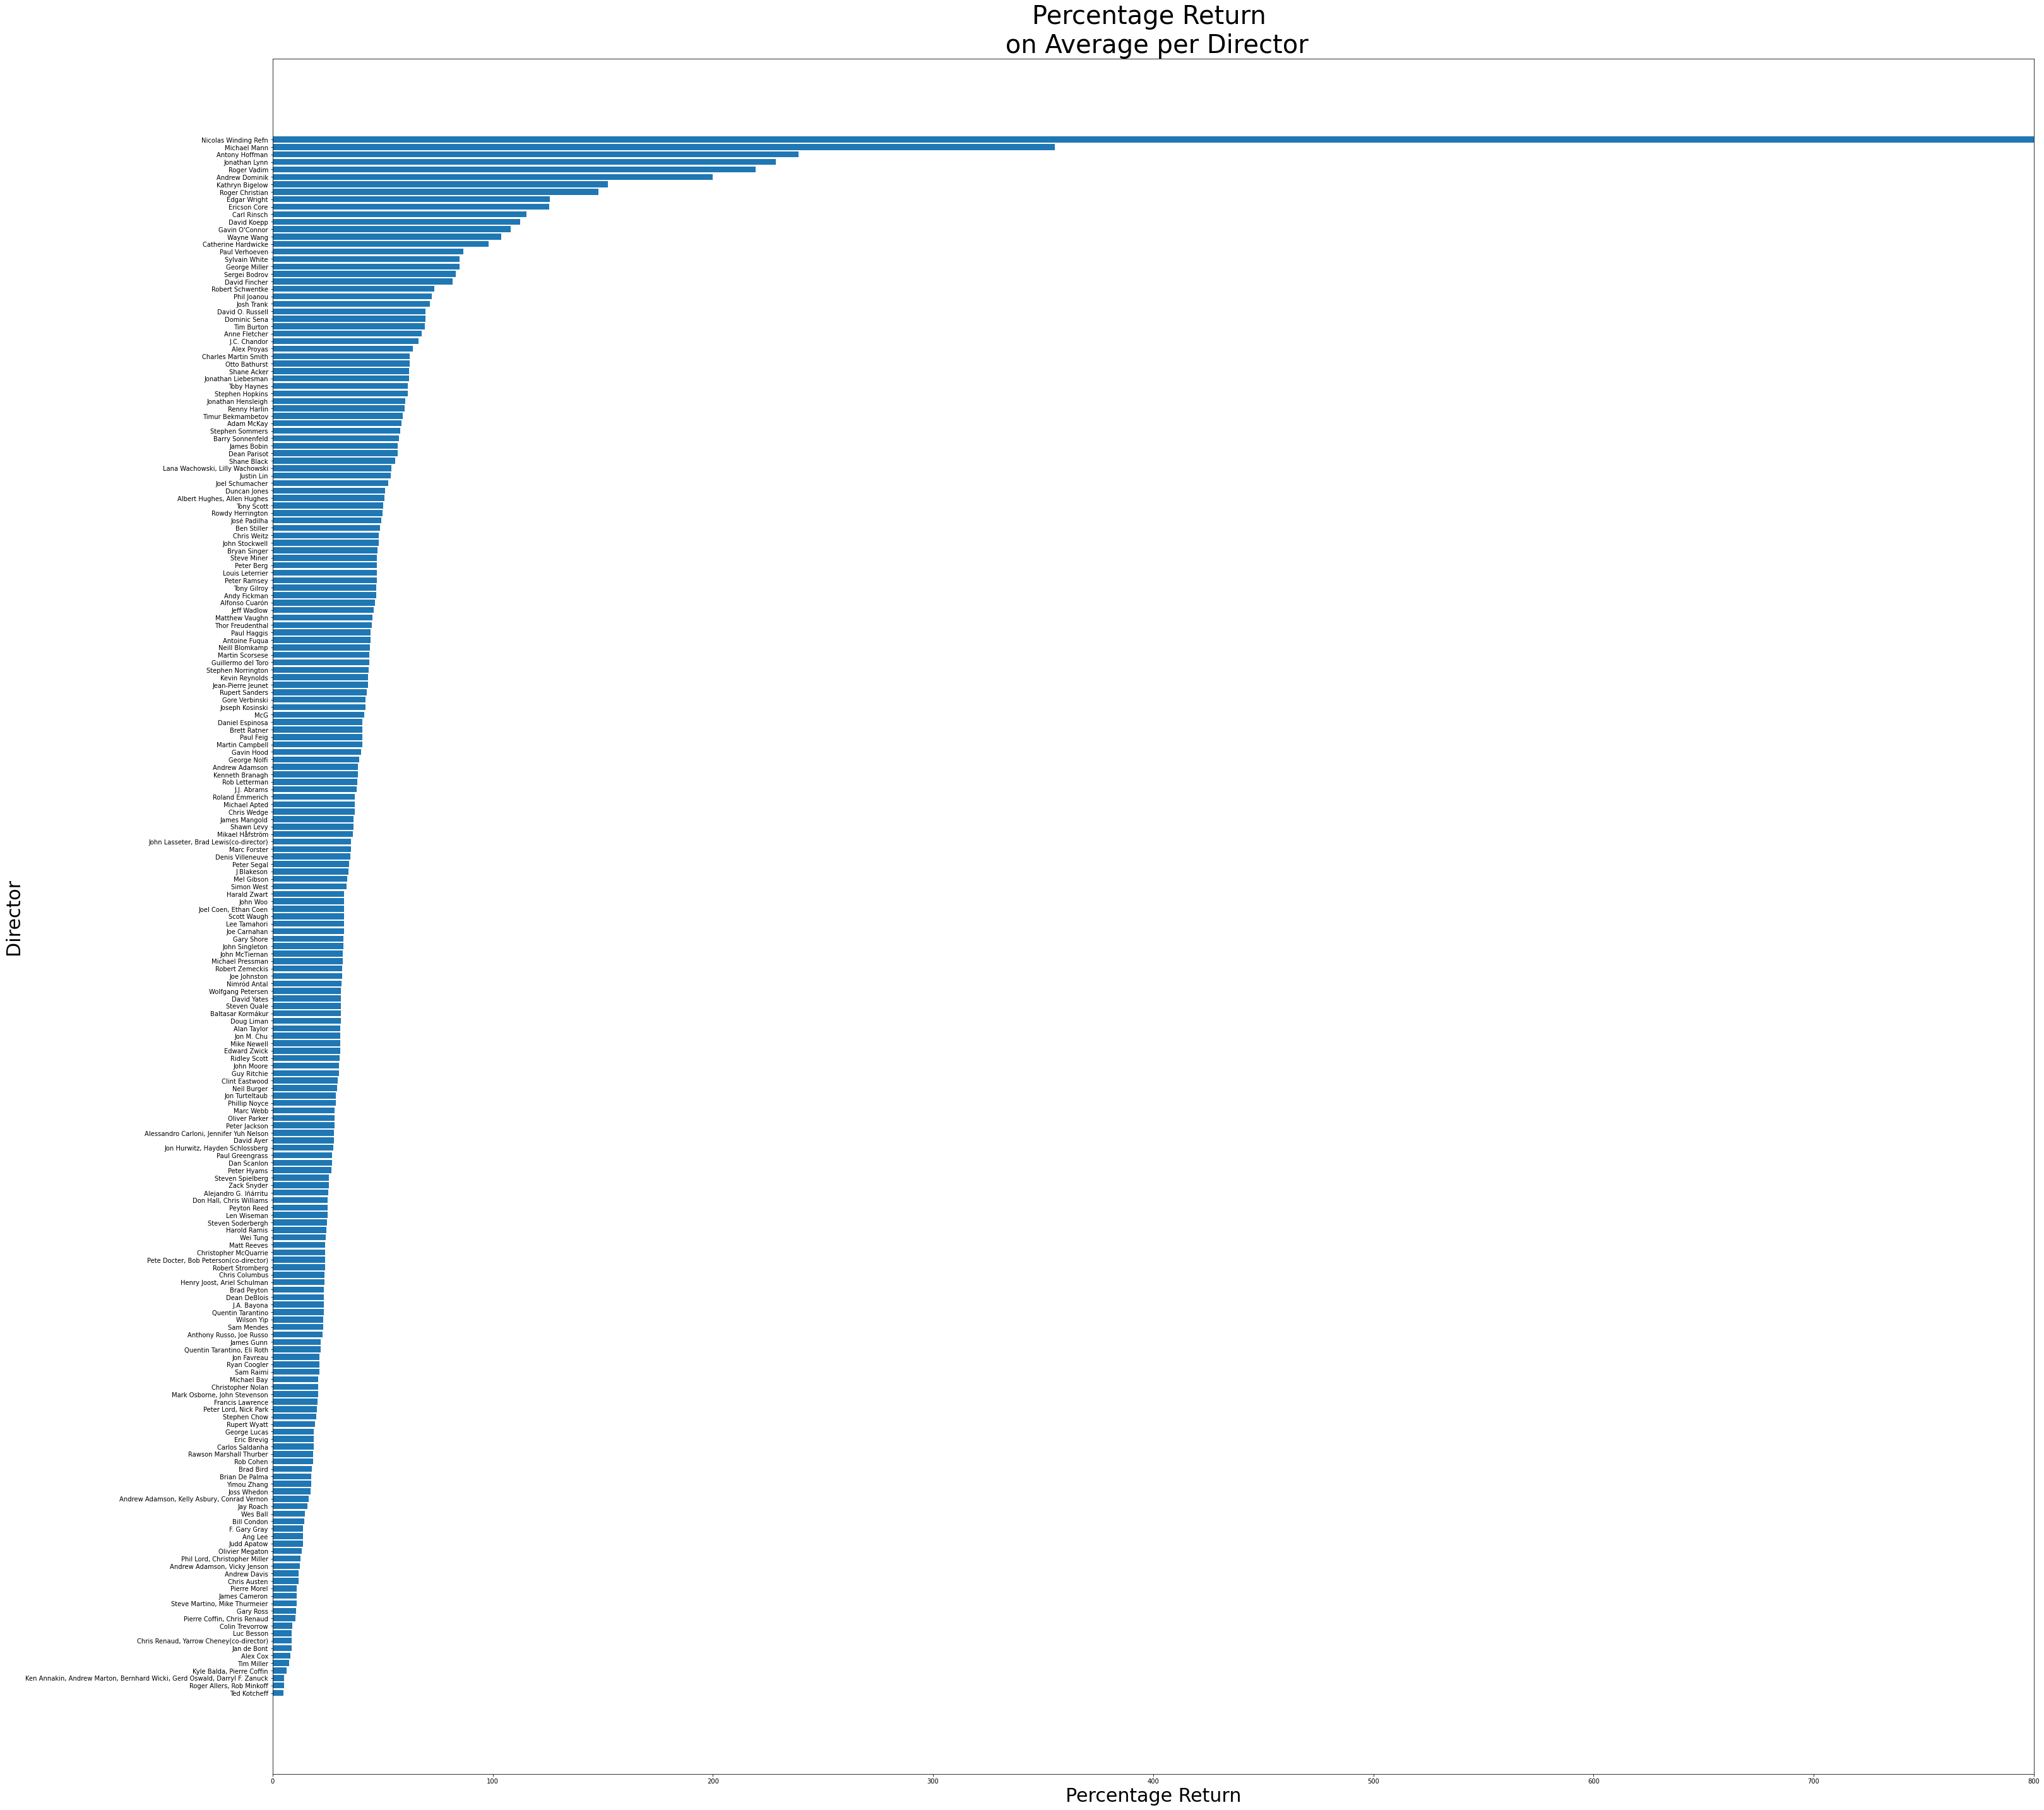

In [58]:
plt.figure(figsize = (50,50))
plt.barh(revenue_director_df.index, revenue_director_df['pct_return'])
plt.title('Percentage Return \n on Average per Director', fontsize = 40)
plt.xlim(0,800)
plt.xlabel('Percentage Return', fontsize = 30)
plt.ylabel('Director', fontsize = 30)
plt.savefig('Percentage Return on Average per Director.png');

Scatter plots of relationship of worldwide-gross to various features such as studio, oscar wins, oscar nomination, total number of awards won, actor_1 and writer_1

<Figure size 2520x504 with 0 Axes>

<Figure size 2520x504 with 0 Axes>

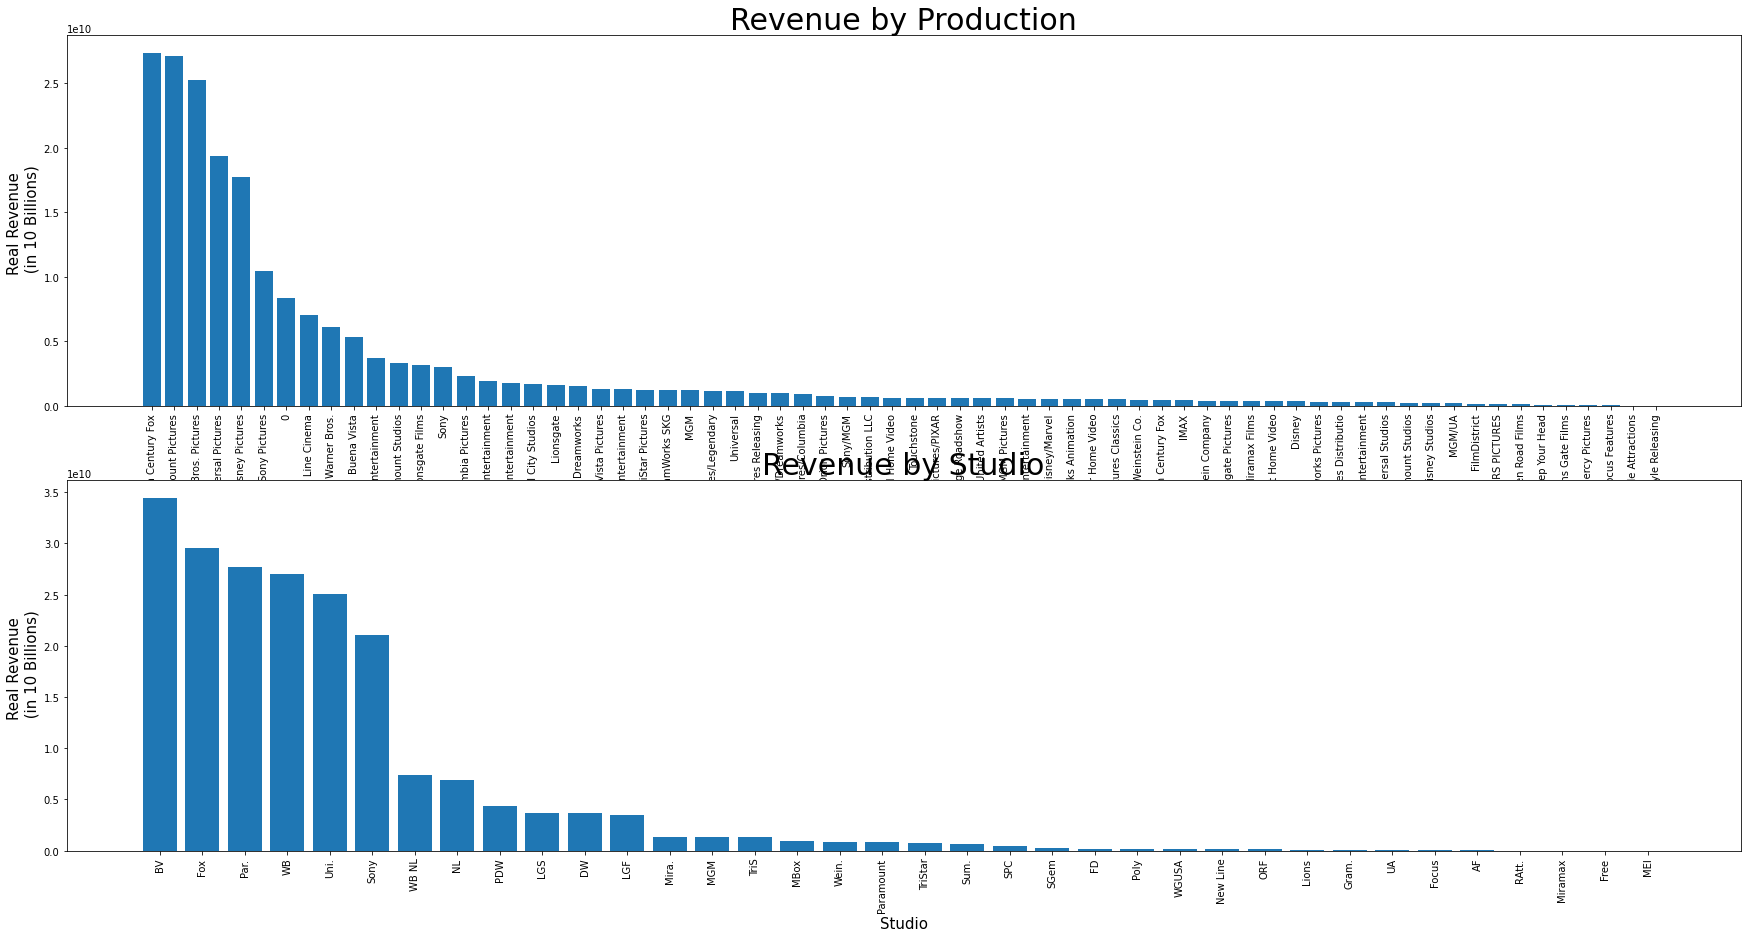

<Figure size 2520x504 with 0 Axes>

In [59]:
# Worldwide-gross to production studio
wwg_production_df = pd.DataFrame(OMdb.groupby(by=['Production']).sum()['real_revenue']).sort_values(by='real_revenue', ascending = False)
plt.figure(figsize = (35,7))
wwg_studio_df = pd.DataFrame(OMdb.groupby(by=['studio']).sum()['real_revenue']).sort_values(by='real_revenue', ascending = False)
plt.figure(figsize = (35,7))

plt.figure(figsize = (30,15))
ax1 = plt.subplot(2,1,1)
ax1.set_title('Revenue by Production', fontsize = 30)
ax1.bar(wwg_production_df.index, wwg_production_df['real_revenue'])
ax1.set_xlabel('Production', fontsize = 15)
ax1.set_xticklabels(wwg_production_df.index, rotation = 90)
ax1.set_ylabel('Real Revenue \n (in 10 Billions)', fontsize = 15)

ax2 = plt.subplot(2,1,2)
ax2.set_title('Revenue by Studio', fontsize = 30)
ax2.bar(wwg_studio_df.index, wwg_studio_df['real_revenue'])
plt.figure(figsize = (35,7))
ax2.set_xlabel('Studio', fontsize = 15)
ax2.set_xticklabels(wwg_studio_df.index, rotation = 90)
ax2.set_ylabel('Real Revenue \n (in 10 Billions)', fontsize = 15)

plt.tight_layout()
plt.savefig('Real Revenue to production studio.png');

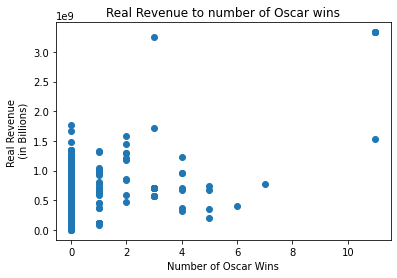

In [60]:
# Worldwide-gross to # of oscar wins
plt.scatter(OMdb['oscar_wins'], OMdb['real_revenue'])
plt.title('Real Revenue to number of Oscar wins')
plt.xlabel('Number of Oscar Wins')
plt.ylabel('Real Revenue \n (in Billions)')
plt.savefig('Real Revenue to number of Oscar wins.png');

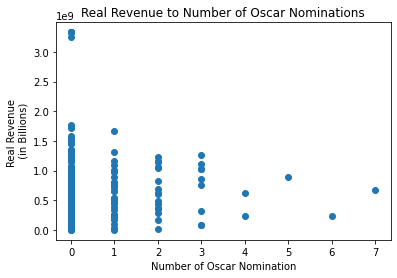

In [61]:
# Worldwide-gross to # of oscar nominations
plt.scatter(OMdb['oscar_noms'], OMdb['real_revenue'])
plt.title('Real Revenue to Number of Oscar Nominations')
plt.xlabel('Number of Oscar Nomination')
plt.ylabel('Real Revenue \n (in Billions)')
plt.savefig('Real Revenue to number of Oscar nominations.png');

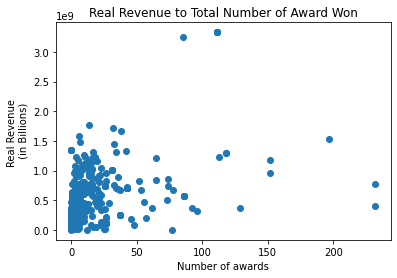

In [62]:
#Worldwide-gross to total # awards won
plt.scatter(OMdb['awards'], OMdb['real_revenue'])
plt.title('Real Revenue to Total Number of Award Won')
plt.xlabel('Number of awards')
plt.ylabel('Real Revenue \n (in Billions)')
plt.savefig('Real Revenue to Total Number of Award Won.png');

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


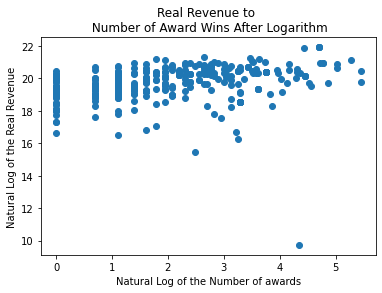

In [63]:
# Try using log to see if any linear relationship?
plt.scatter(np.log(OMdb['awards']), np.log(OMdb['real_revenue']))
plt.title('Real Revenue to \n Number of Award Wins After Logarithm')
plt.xlabel('Natural Log of the Number of awards')
plt.ylabel('Natural Log of the Real Revenue')
plt.savefig('Real Revenue to Number of Award Wins After Logarithm.png');

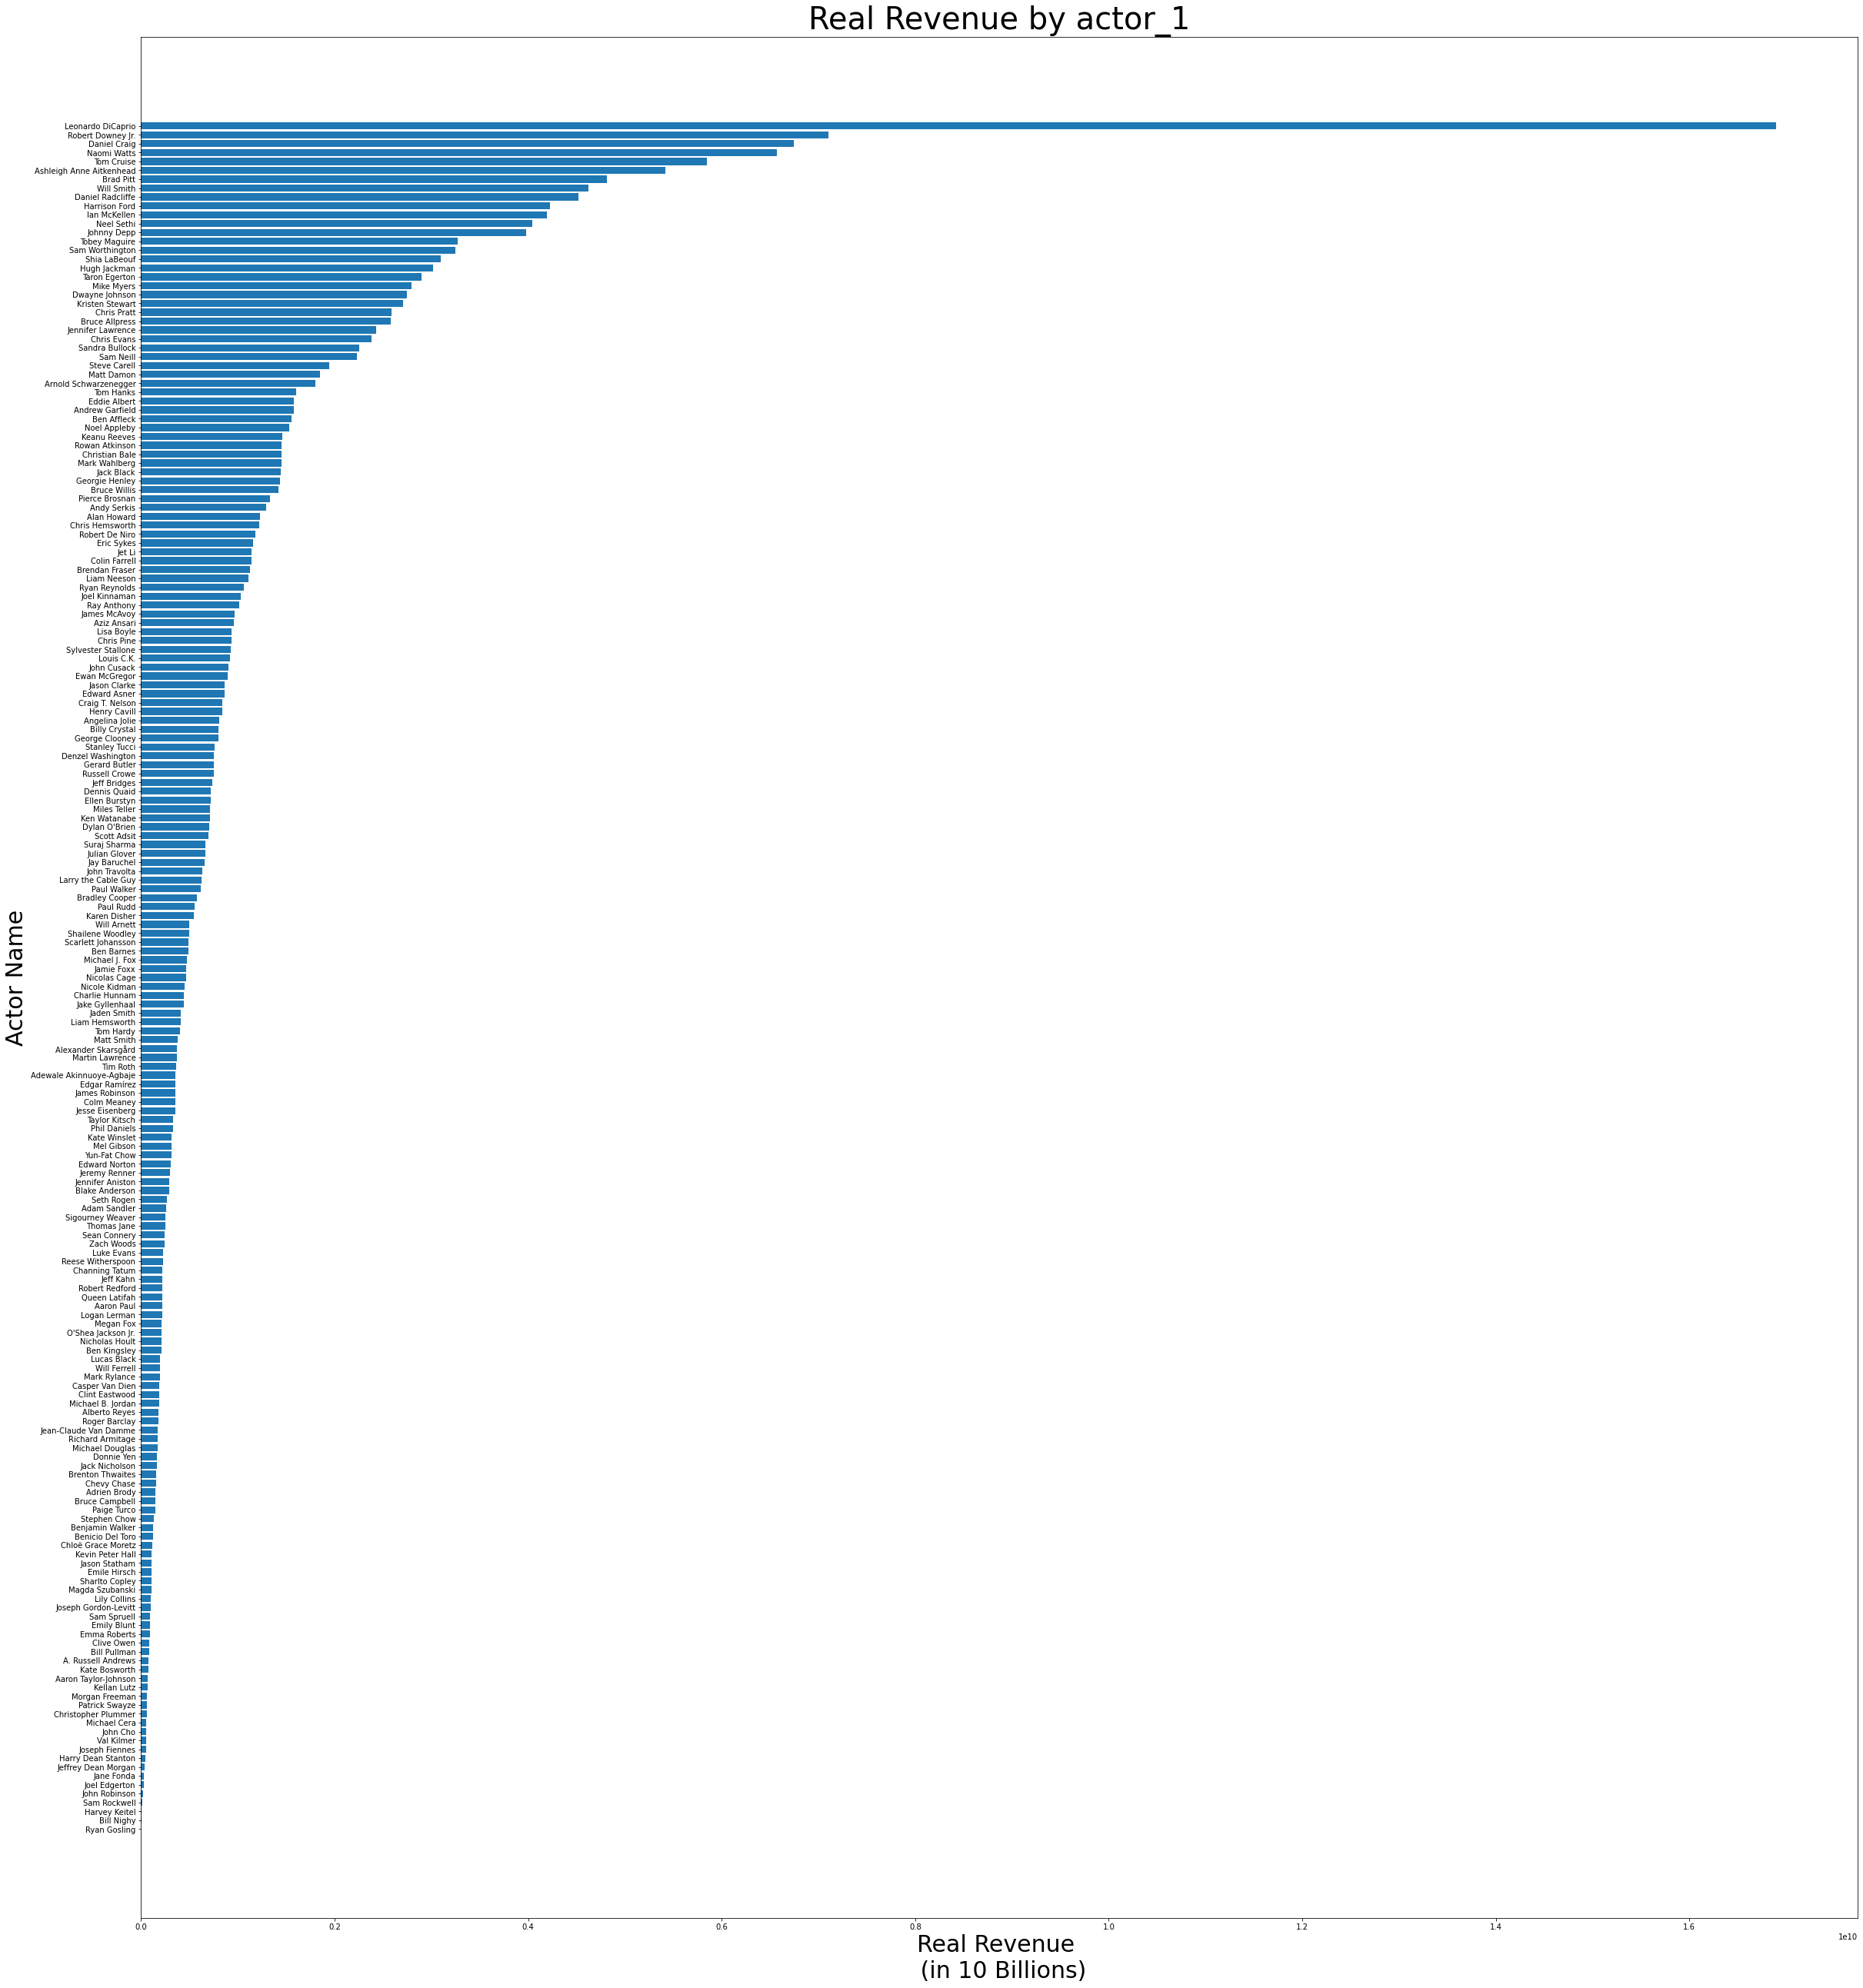

In [64]:
# Worldwide-gross to actor_1
wwg_actor1_df = pd.DataFrame(OMdb.groupby(by=['actor_1']).sum()['real_revenue']).sort_values(by='real_revenue')
plt.figure(figsize = (40,45))
plt.barh(wwg_actor1_df.index, wwg_actor1_df['real_revenue'])
plt.title('Real Revenue by actor_1', fontsize = 40)
plt.xlabel('Real Revenue \n (in 10 Billions)', fontsize = 30)
plt.ylabel('Actor Name', fontsize = 30)
plt.savefig('Real Revenue by actor_1.png');

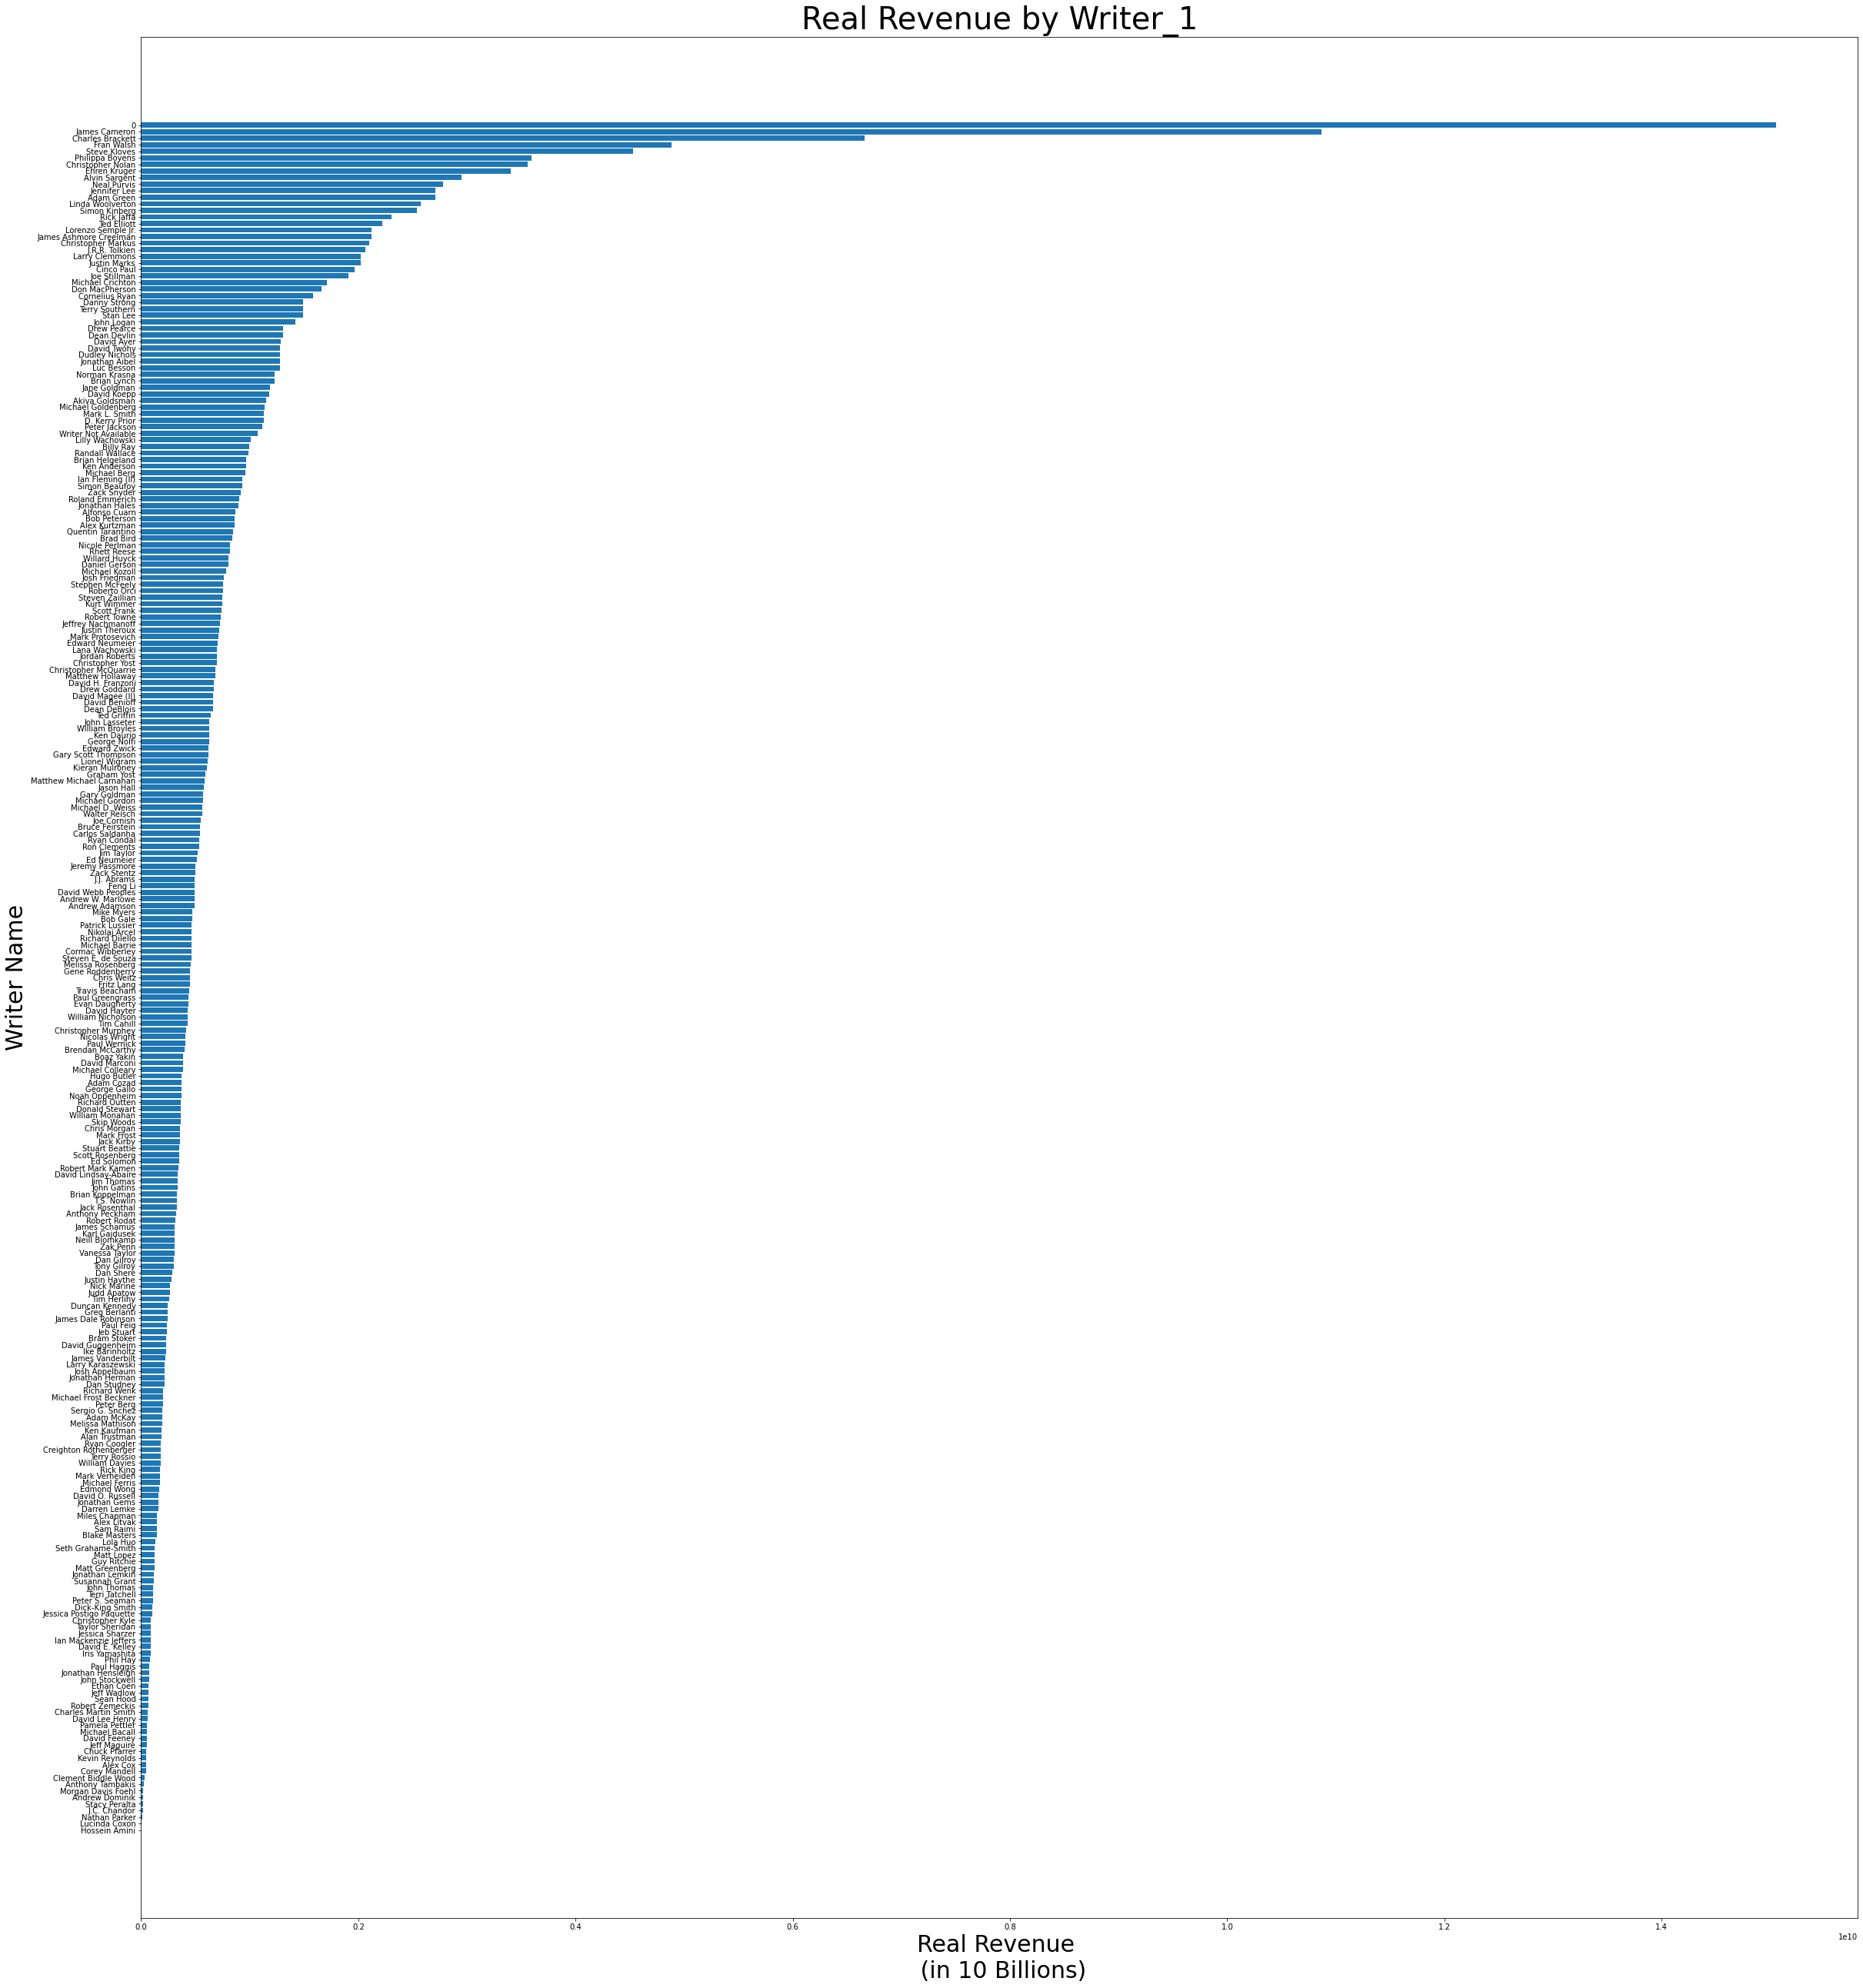

In [65]:
# Worldwide-gross to writer_1
wwg_writer_df = pd.DataFrame(OMdb.groupby(by=['Writer 1']).sum()['real_revenue']).sort_values(by='real_revenue')
plt.figure(figsize = (40,45))
plt.barh(wwg_writer_df.index, wwg_writer_df['real_revenue'])
plt.title('Real Revenue by Writer_1', fontsize = 40)
plt.xlabel('Real Revenue \n (in 10 Billions)', fontsize = 30)
plt.ylabel('Writer Name', fontsize = 30)
plt.savefig('Real Revenue by Writer_1.png');